In [1]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision import models
from pytorch_lightning.loggers import WandbLogger
from torchvision.datasets import ImageFolder
from torchvision import transforms
import pytorch_lightning as pl
import cv2
from torch.nn import functional as F
import wandb
import torchmetrics
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
dataset_dir = Path('Birds')

In [3]:
class BirdsModel(pl.LightningModule):
    
    def __init__(self, num_classes=400, model='efficientnet_b1', dropout=0.2):
        super().__init__()
        backbones = {
            'resnet-50': (models.resnet50(pretrained=True), 'fc', 2048),
            'mobilenet_v3': (models.mobilenet_v3_small(pretrained=True), 'classifier', 576),
            'efficientnet_b1': (models.efficientnet_b1(pretrained=True), 'classifier', 1280),
            'efficientnet_b4': (models.efficientnet_b4(pretrained=True), 'classifier', 1792)
        }
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        self.val_confmat = torchmetrics.ConfusionMatrix(num_classes=num_classes)
        self.encoder, self.name, in_shape = backbones[model]
        for param in self.encoder.parameters():
            param.requires_grad = False
        classifier = torch.nn.Sequential(
            torch.nn.Linear(in_shape, 2048),
            torch.nn.SiLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(2048, num_classes)
        )
        setattr(self.encoder, self.name, classifier)
        plt.figure(figsize=(10, 10))

    def forward(self, x):
        preds = self.encoder(x)
        return preds
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(getattr(self.encoder, self.name).parameters(), lr=1e-3)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)
        return [optimizer], [lr_scheduler]
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self(x)
        #print(y_hat.shape, y.shape)
        #print(torch.argmax(y_hat, 1), y)
        #return None
        batch_value = self.train_acc(y_hat, y)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc_step', batch_value)
        return loss
    
    def training_epoch_end(self, outputs):
        self.train_acc.reset()
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        y_hat = self(x)
        self.test_acc.update(y_hat, y)
    
    def test_epoch_end(self, outputs):
        self.log('test_acc_epoch', self.test_acc.compute())
        self.test_acc.reset()
        
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss)
        self.valid_acc.update(y_hat, y)
        self.val_confmat.update(y_hat, y)
        
    def validation_epoch_end(self, outputs):
        self.log('valid_acc_epoch', self.valid_acc.compute())
        cm = plt.imshow(self.val_confmat.confmat.detach().cpu().numpy(), cmap='hot', interpolation='nearest')
        self.logger.experiment.log(
            {
                "conf_matrix": [wandb.Image(cm)]
            }
        )
        self.valid_acc.reset()
        self.val_confmat.reset()
        del cm

In [4]:
class BirdsDataModule(pl.LightningDataModule):
    
    def train_dataloader(self):
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomAffine(10, scale=(0.95, 1.05)),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(), 
                                                        transforms.GaussianBlur(3)]), p=0.1),
            transforms.Resize(256),
            transforms.CenterCrop(240),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.RandomErasing(p=0.14, value='random')
        ])
        train_dataset = ImageFolder(str(Path(dataset_dir, "train")), transform=transform)
        print(len(train_dataset))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=800, num_workers=6, shuffle=True, prefetch_factor=2)
        return train_loader
    
    def val_dataloader(self):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        val_dataset = ImageFolder(str(Path(dataset_dir, "valid")), transform=transform)
        print(len(val_dataset))
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=500, num_workers=4)
        return val_loader

400
58388


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

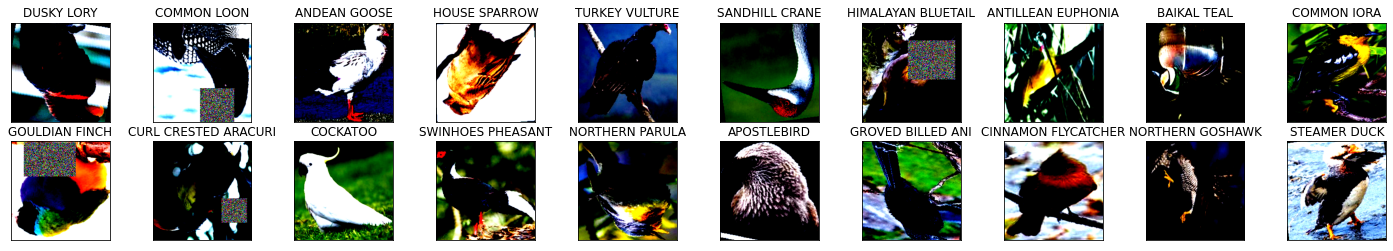

In [5]:
classes = list(pd.read_csv(str(Path(dataset_dir, "class_dict.csv")))['class'])
print(len(classes))
data_module = BirdsDataModule()
dataiter = iter(data_module.train_dataloader())
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Распределенное обучение
В ноутбуке можно использовать только dataparallel\
Если перенести все в питоновский файл, можно подключить strategy='ddp' или startegy='horovod' для обучения на разных нодах

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='final_model-epoch{epoch:02d}-val_loss{val/loss:.2f}',
    auto_insert_metric_name=False
)
test_models = ['efficientnet_b1']
dropouts = [0.4]
for dropout in dropouts:
    for backbone in test_models:
        model = BirdsModel(model=backbone, dropout=dropout)
        wandb.login()
        wandb_logger = WandbLogger(project="SberBirdsTestAssignment", name='final_model')
        trainer = pl.Trainer(devices=1, accelerator="gpu", strategy="dp", logger=wandb_logger, max_epochs=20, callbacks=[checkpoint_callback])
        trainer.fit(model, data_module)
        wandb.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/jood/miniconda3/envs/sync/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type            | Params
------------------------------------------------
0 | train_acc   | Accuracy        | 0     
1 | valid_acc   | Accuracy        | 0     
2 | val_confmat | ConfusionMatrix | 0     
3 | encoder     | EfficientNet    | 10.0 M
------------------------------------------------
3.4 M     Trainable params
6.5 M     Non-trainable params
10.0 M    Total params
39.825    Total estimated model params size (MB)
/home/jood/miniconda3/envs/sync/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:

Validation sanity check: 0it [00:00, ?it/s]

2000


wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


58388


Training: 0it [00:00, ?it/s]

/home/jood/miniconda3/envs/sync/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Посмотрим на результаты обученной модели

In [19]:
def test_dataloader():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    test_dataset = ImageFolder(str(Path(dataset_dir, "test")), transform=transform)
    print(len(test_dataset))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, num_workers=4)
    return test_loader

In [20]:
model = BirdsModel(model='efficientnet_b1')
trainer = pl.Trainer(gpus=1)
trainer.test(model=model, dataloaders=test_dataloader(), ckpt_path=str(Path('checkpoints', 'final_model-epoch19-val_loss0.00.ckpt')), verbose=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Restoring states from the checkpoint path at checkpoints/final_model-epoch19-val_loss0.00.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at checkpoints/final_model-epoch19-val_loss0.00.ckpt


2000


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc_epoch': 0.9570000171661377}
--------------------------------------------------------------------------------


[{'test_acc_epoch': 0.9570000171661377}]

<Figure size 720x720 with 0 Axes>

## Сохраним веса модели для vanilla pytorch

In [4]:
class BirdsModelProd(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = models.efficientnet_b1(pretrained=True)
        self.encoder.classifier = torch.nn.Sequential(
            torch.nn.Linear(1280, 2048),
            torch.nn.SiLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(2048, 400)
        )

    def forward(self, x):
        return self.encoder(x)

In [5]:
model = BirdsModelProd()
model.load_state_dict(torch.load(str(Path('checkpoints', 'final_model-epoch19-val_loss0.00.ckpt')))['state_dict'])

<All keys matched successfully>

In [6]:
torch.save(model.state_dict(), 'final_model.pth')